<div class="usecase-title">Optimising Parking Accessibility Near Healthcare and Educational Facilities in Melbourne</div>

<div class="usecase-authors"><b>Authored by: </b> Nattakan Owatwansakul</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data cleaning, Data analysis, Data visualisation</div>
</div>

<div class="usecase-section-header">Scenario</div>

As an urban planner in the city of Melbourne, I want to identify areas near healthcare and educational facilities where parking is limited but demand is high, So that I can make informed decisions about improving parking infrastructure and accessibility for patients, students, and staff.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Learn how to import and combine data from various sources.
- Understand relationship between parking demand, pedestrian traffic and public facilities.
- Gain skills in analysing data and presenting data insights for clients

<div class="usecase-section-header">Introduction</div>

In growing cities like Melbourne, healthcare and educational facilities are essential parts of the community and attract high numbers of daily visitors. These places often have a lot of foot traffic, especially during rush hours. However, there is not always enough parking nearby for patients, students, and staff. This can cause inconvinience, delays, and access issues, especially for patients, students, and people who need these services.

This use case aims to explore parking accessibility around healthcare and educational institutions in Melbourne. By analysing data on car park capacity, facility locations, and pedestrian movement, the project seeks to identify areas with high demand but limited parking. The results will support urban planners in making informed decisions to improve parking infrastructure and future city planning.

<div class="usecase-section-header">Datasets</div>

- <strong>[Off-street car parks with capacity and type](https://data.melbourne.vic.gov.au/explore/dataset/off-street-car-parks-with-capacity-and-type/information/)</strong><br>
      Data collected as part of the City of Melbourne's Census of Land Use and Employment (CLUE). The data covers the period 2002-2023.
- <strong>[Landmarks and places of interest, including schools, theatres, health services, sports facilities, places of worship, galleries and museums](https://data.melbourne.vic.gov.au/explore/dataset/landmarks-and-places-of-interest-including-schools-theatres-health-services-spor/information/)</strong><br>
    Dataset contains a description and co-ordinates of places of interest within the City of Melbourne.
- <strong>[Pedestrian Counting System (counts per hour)](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)</strong><br>
This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day.
- <strong>[Bus stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)</strong><br>
This data set shows the locations of the bus stops within the city of Melbourne, As the city of Melbourne do not run the bus services, this is simply to show the locations of the stops, this data does not include the services that run from each of the stops.
- <strong>[Tram Tracks](https://data.melbourne.vic.gov.au/explore/dataset/tram-tracks/information/)</strong><br>
This dataset is a shapefile that contains all of the tram tracks within the city of Melbourne, this data set is generally used for City of Melbourne related queries, therefor we do not hold the entire tram network

# Import Libraries

In [1]:
#for using APIs
import requests
#data monipulation and analysis
import pandas as pd
# convert text
from io import StringIO
import math
#calculate distance between two points
from geopy.distance import geodesic
#interactive map
import folium
from collections import Counter
from branca.element import Template, MacroElement
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Loading data through APIs V2.1 from CoM open data portal

We define a function that connects to the City of Melbourne’s Open Data platform to automatically retrieve datasets relevant to this project. Rather than downloading files manually, this function sends a request to the data portal through a web address (API) and asks for the entire dataset. The data is then converted into a format suitable for analysis in Python, using `pandas`.

This method ensures we are working with the most current and complete data available. In this use case, we use it to load datasets such as landmarks (including schools, libraries, and health services), parking availability, and pedestrian traffic. This approach improves efficiency, keeps the project up to date, and reduces the risk of human error associated with manual downloads.

In [63]:
def API_Unlimited(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = 'apikey
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [65]:
landmark_location = API_Unlimited('landmarks-and-places-of-interest-including-schools-theatres-health-services-spor')
parking_capacity = API_Unlimited('off-street-car-parks-with-capacity-and-type')
pedestrian_count = API_Unlimited('pedestrian-counting-system-monthly-counts-per-hour')
bus_stop = API_Unlimited('bus-stops')
tram_stop = API_Unlimited('tram-tracks')

Request failed with status code 404


In [176]:
bus_stop = API_Unlimited('bus-stops')
tram_stop = API_Unlimited('tram-tracks')

## Previewing the Raw Datasets
1. The **landmark** dataset contains important public locations across Melbourne, such as schools, health services, and places of worship. It includes columns like `theme`, `sub_theme`, `feature_name`, and `co_ordinates` (latitude and longitude combined). This information helps us later identify which landmarks are near public parking or pedestrian sensors.

In [134]:
landmark_location.head()

theme sub_theme                 feature_name  \
0  Place of Worship    Church            St Francis Church   
1  Place of Worship    Church              St James Church   
2  Place of Worship    Church    St Mary's Anglican Church   
3  Place of Worship    Church                 Scots Church   
4  Place of Worship    Church  St Michael's Uniting Church   

                          co_ordinates  
0  -37.8118847831837, 144.962422614541  
1  -37.8101281201969, 144.952468571683  
2  -37.8031663672997, 144.953761537074  
3   -37.8145687802664, 144.96855105335  
4  -37.8143851324913, 144.969174036096

2. The **parking capacity** dataset provides details about off-street parking facilities, such as the `census_year`, `block_id`, `property_id`, `base_property_id`, `building_address`, number of `parking_spaces`, and `parking_type` (e.g., Public, Private, or Residential). It also contains `location` data in separate `latitude` and `longitude` columns. However, this dataset includes private and residential car parks, which are not publicly available. We will filter those out in later steps to focus only on publicly usable parking spaces.

In [137]:
parking_capacity.head()

census_year  block_id  property_id  base_property_id  \
0         2019        57       101213            101213   
1         2019        57       101219            101219   
2         2019        58       101231            101231   
3         2019        58       101232            101232   
4         2019        58       105659            105659   

                        building_address  clue_small_area parking_type  \
0   134-144 Bourke Street MELBOURNE 3000  Melbourne (CBD)      Private   
1   100-116 Bourke Street MELBOURNE 3000  Melbourne (CBD)      Private   
2     40-50 Bourke Street MELBOURNE 3000  Melbourne (CBD)  Residential   
3     32-38 Bourke Street MELBOURNE 3000  Melbourne (CBD)      Private   
4  16-22 Liverpool Street MELBOURNE 3000  Melbourne (CBD)  Residential   

   parking_spaces   longitude   latitude  \
0              30  144.968839 -37.812035   
1              68  144.969761 -37.811727   
2              26  144.971692 -37.811371   
3               5  144.971978 -37.811361   
4              85  144.971543 -37.811060   

                                 location  
0      -37.81203485275635, 144.9688385527  
1  -37.81172679558099, 144.96976088474997  
2      -37.81137105206584, 144.9716919528  
3     -37.81136084732718, 144.97197812345  
4     -37.81105967715, 144.97154296349532

3. The **pedestrian count** dataset records hourly foot traffic from sensors placed around the city. Each row includes the sensor `location_id`, date and hour of measurement (`sensing_date`, `hourday`), the number of people counted in each `direction`, and the total `pedestriancount`. The `location` column provides the coordinates of each sensor, which we will use to match with landmarks later.

In [140]:
pedestrian_count.head()

id  location_id sensing_date  hourday  direction_1  direction_2  \
0  772020210812           77   2021-08-12       20          106          126   
1  281120210720           28   2021-07-20       11           38           64   
2   40320221228           40   2022-12-28        3            1            1   
3   17620220503           17   2022-05-03        6          114           59   
4  123620241128          123   2024-11-28        6            6            2   

   pedestriancount  sensor_name                    location  
0              232     HarEsP_T  -37.81441438, 144.94433026  
1              102        VAC_T  -37.82129925, 144.96879309  
2                2     Spr201_T  -37.80999341, 144.97227587  
3              173      Col15_T  -37.81362543, 144.97323591  
4                8  BirBridge_T  -37.81753741, 144.97329734

4. The **bus stops** dataset shows the locations of bus stop signage across Melbourne. Each row includes a `geo_point_2d` column with the coordinates (latitude and longitude) and a `description` column that describes the bus stop type. Other attributes such as `roadseg_id` and `model_no` provide additional details about the stop. We will use the coordinate data to find bus stops near healthcare and educational facilities. This helps us check public transport accessibility, which may reduce parking demand if many people can reach the area by bus.


In [143]:
bus_stop.head()

geo_point_2d  \
0  -37.80384165792465, 144.93239283833262   
1   -37.81548699581418, 144.9581794249902   
2  -37.81353897396532, 144.95728334230756   
3  -37.82191394843844, 144.95539345270072   
4  -37.83316401267591, 144.97443745130263   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.93239283833262, -37.80384...        0   76.819824   
1  {"coordinates": [144.9581794249902, -37.815486...        0   21.561304   
2  {"coordinates": [144.95728334230756, -37.81353...        0   42.177187   
3  {"coordinates": [144.95539345270072, -37.82191...        0   15.860434   
4  {"coordinates": [144.97443745130263, -37.83316...        0    0.000000   

   addressp_1 asset_clas               asset_type  objectid   str_id  \
0         357    Signage  Sign - Public Transport       355  1235255   
1          83    Signage  Sign - Public Transport       600  1231226   
2         207    Signage  Sign - Public Transport       640  1237092   
3         181    Signage  Sign - Public Transport       918  1232777   
4           0    Signage  Sign - Public Transport      1029  1271914   

   addresspt  asset_subt                       model_desc   mcc_id  \
0     570648         NaN  Sign - Public Transport 1 Panel  1235255   
1     548056         NaN  Sign - Public Transport 1 Panel  1231226   
2     543382         NaN  Sign - Public Transport 1 Panel  1237092   
3     103975         NaN  Sign - Public Transport 1 Panel  1232777   
4          0         NaN  Sign - Public Transport 1 Panel  1271914   

   roadseg_id                                        descriptio model_no  
0       21673  Sign - Public Transport 1 Panel Bus Stop Type 13     P.16  
1       20184   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
2       20186   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
3       22174   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
4       22708   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16

5. The **tram tracks** dataset shows the paths where tram lines are located across Melbourne. Each row includes `geo_point_2d`, which gives the approximate location (latitude and longitude), and `geo_shape`, which provides the full shape of the tram track route using multiple coordinates. Other columns like `description` and `name` provide simple identifiers for the tram routes. We will use this data to map tram lines and see how close they are to important landmarks. This helps assess tram accessibility and how it may influence parking needs in each area.


In [146]:
tram_stop.head()

descriptio   name   latitude  \
0  <center><table><tr><th colspan='2' align='cent...  kml_3 -37.788613   
1  <center><table><tr><th colspan='2' align='cent...  kml_5 -37.819186   
2  <center><table><tr><th colspan='2' align='cent...  kml_6 -37.818380   
3  <center><table><tr><th colspan='2' align='cent...  kml_7 -37.814404   
4  <center><table><tr><th colspan='2' align='cent...  kml_8 -37.816739   

    longitude  
0  144.934616  
1  144.961035  
2  144.959453  
3  144.970251  
4  144.969909

# Data Preprocessing

## Landmarks and places of interest, including schools, theatres, health services, sports facilities, places of worship, galleries and museums
This dataset includes a wide range of place types, such as schools, theatres, health services, sports facilities, galleries and more. For this project, we filtered the data to include only **Health Services and Education Centres**, as these locations are our primary focus for improving parking accessibility. These sites deliver essential public services and often experience high visitor volumes. We also included **libraries** (filtered from the “Community Use” category)

In [150]:
def filter_landmarks(data):
    #choose only heath services and edication centre theme
    themes = ["Health Services", "Education Centre"]
    filtered_theme = data[data['theme'].isin(themes)]

    #from 'Community Use' theme, include only libraries
    community_use = data[
        (data['theme'] == "Community Use") &
        (data['feature_name'].str.contains("library", case=False, na=False))
    ]

    filtered_landmarks = pd.concat([filtered_theme, community_use], ignore_index=True)
    return filtered_landmarks


In [152]:
filtered_landmarks = filter_landmarks(landmark_location)

#split 'co_ordinates' column into 'latitude' and 'longitude' columns
filtered_landmarks[['latitude', 'longitude']] = filtered_landmarks['co_ordinates'].str.split(',', expand=True)

#change string to float
filtered_landmarks['latitude'] = filtered_landmarks['latitude'].astype(float)
filtered_landmarks['longitude'] = filtered_landmarks['longitude'].astype(float)
filtered_landmarks = filtered_landmarks.drop(columns=['co_ordinates'])

#check missing values
print(filtered_landmarks.isnull().sum())

theme           0
sub_theme       0
feature_name    0
latitude        0
longitude       0
dtype: int64


In [154]:
filtered_landmarks.head()

theme          sub_theme  \
0  Education Centre    Primary Schools   
1  Education Centre  Secondary Schools   
2   Health Services   Private Hospital   
3   Health Services    Public Hospital   
4   Health Services    Public Hospital   

                                   feature_name   latitude   longitude  
0                Carlton Gardens Primary School -37.802095  144.969406  
1                      Melbourne Grammar School -37.834256  144.976285  
2  Epworth Freemasons Hospital : Medical Centre -37.809344  144.982337  
3                         Royal Womens Hospital -37.798889  144.954897  
4                      Royal Childrens Hospital -37.794206  144.950048

## Off-street car parks with capacity and type
The most recent available data for this dataset was collected in 2023, which has been used in this project due to the absence of newer data for 2024. We filtered the dataset to retain only **public or mixed-use parking facilities**, removing private and residential-only parking. This ensures our analysis targets parking options that are accessible to patients, students, staff and the general public, supporting real-world usability.

In [157]:
#use the data only in 2023
parking_2023 = parking_capacity[parking_capacity['census_year'] == 2023]

#define types of parking which are public spaces
public_parking_types = [
    "Commercial",
    "Commercial, Private",
    "Commercial, Residential",
    "Commercial, Private, Residential"
]

#filter the data to includes only public parkings
filtered_parking = parking_2023[parking_2023['parking_type'].isin(public_parking_types)]

#group data by lcoation
filtered_parking = filtered_parking.groupby(['latitude', 'longitude', 'building_address', 'clue_small_area'], as_index=False).agg({
    'parking_spaces': 'sum',
    'parking_type': lambda x: ', '.join(sorted(set(x)))  
})

#check missing values
print(filtered_parking.isnull().sum())



latitude            0
longitude           0
building_address    0
clue_small_area     0
parking_spaces      0
parking_type        0
dtype: int64


In [159]:
filtered_parking.head()

latitude   longitude                                   building_address  \
0 -37.846853  144.980378               553 St Kilda Road MELBOURNE VIC 3004   
1 -37.846570  144.982816  Alfred Hospital 23-99 Commercial Road PRAHRAN ...   
2 -37.844593  144.979288               517 St Kilda Road MELBOURNE VIC 3004   
3 -37.837746  144.977044           415-421 St Kilda Road MELBOURNE VIC 3004   
4 -37.829090  144.970686           312-318 St Kilda Road SOUTHBANK VIC 3006   

         clue_small_area  parking_spaces parking_type  
0  Melbourne (Remainder)             183   Commercial  
1  Melbourne (Remainder)            1729   Commercial  
2  Melbourne (Remainder)               8   Commercial  
3  Melbourne (Remainder)              98   Commercial  
4              Southbank             240   Commercial

## Pedestrian Counting System (counts per hour)
We filtered the pedestrian counting dataset to include only data from 2024 to the most recent available date. This allows us to understand recent trends in foot traffic near healthcare and educational facilities. By identifying areas with high pedestrian activity and their peak hours, we can align parking demand with actual usage patterns.

In [162]:
#convert sensing_date to datetime format
pedestrian_count['sensing_date'] = pd.to_datetime(pedestrian_count['sensing_date'])

#filter data to include only records from 2024
filtered_pedestrian = pedestrian_count[pedestrian_count['sensing_date'].dt.year >= 2024].copy()
#split the 'location' column into separate latitude and longitude columns
filtered_pedestrian[['latitude', 'longitude']] = filtered_pedestrian['location'].str.split(',', expand=True)

#convert string to float
filtered_pedestrian['latitude'] = filtered_pedestrian['latitude'].astype(float)
filtered_pedestrian['longitude'] = filtered_pedestrian['longitude'].astype(float)
#drop unnecessary columns
filtered_pedestrian = filtered_pedestrian.drop(columns=['id', 'direction_1', 'direction_2', 'sensor_name', 'location'])

#check missing values
print(filtered_pedestrian.isnull().sum())

location_id        0
sensing_date       0
hourday            0
pedestriancount    0
latitude           0
longitude          0
dtype: int64


In [163]:
filtered_pedestrian.head()

location_id sensing_date  hourday  pedestriancount   latitude   longitude
4           123   2024-11-28        6                8 -37.817537  144.973297
6           167   2025-03-24       13               94 -37.813041  144.951560
8            50   2024-06-20        1                1 -37.798082  144.967210
10           79   2024-11-11        9              867 -37.817940  144.966167
11           39   2025-03-08        6                7 -37.813797  144.969957

## Bus stops
We filtered and cleaned the bus stops dataset to prepare it for analysis. The latitude and longitude information was extracted from the geo_point_2d column to make it easier to use for mapping and distance calculations. Unnecessary columns, such as asset details and shape information, were removed to keep only relevant data. This cleaned dataset allows us to easily find bus stops near healthcare and educational facilities to better understand public transport accessibility.

In [178]:
#split 'geo_point_2d' into latitude and longitude
bus_stop[['latitude', 'longitude']] = bus_stop['geo_point_2d'].str.split(',', expand=True)

bus_stop['latitude'] = bus_stop['latitude'].astype(float)
bus_stop['longitude'] = bus_stop['longitude'].astype(float)

# drop unnecessary columns
columns_to_drop = ['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 
                   'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 
                   'asset_subt', 'model_desc', 'mcc_id']

bus_stop = bus_stop.drop(columns=columns_to_drop)

#check missing values
print(bus_stop.isnull().sum())


roadseg_id    0
descriptio    0
model_no      0
latitude      0
longitude     0
dtype: int64


In [180]:
bus_stop.head()

roadseg_id                                        descriptio model_no  \
0       21673  Sign - Public Transport 1 Panel Bus Stop Type 13     P.16   
1       20184   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
2       20186   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
3       22174   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
4       22708   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   

    latitude   longitude  
0 -37.803842  144.932393  
1 -37.815487  144.958179  
2 -37.813539  144.957283  
3 -37.821914  144.955393  
4 -37.833164  144.974437

## Tram tracks
We cleaned the tram tracks dataset to make it ready for analysis and mapping. The latitude and longitude were extracted from the geo_point_2d column so we can easily calculate distances and visualise tram locations on the map. Unnecessary columns, such as shape details and descriptions, were removed to keep the data simple and focused. This cleaned dataset allows us to find tram tracks near healthcare and educational facilities to help assess how well public transport serves these areas.

In [183]:
#wplit 'geo_point_2d' into latitude and longitude
tram_stop[['latitude', 'longitude']] = tram_stop['geo_point_2d'].str.split(',', expand=True)

tram_stop['latitude'] = tram_stop['latitude'].astype(float)
tram_stop['longitude'] = tram_stop['longitude'].astype(float)

# drop unnecessary columns
columns_to_drop = ['geo_point_2d', 'geo_shape', 'descriptio']

tram_stop = tram_stop.drop(columns=columns_to_drop)

# check missing values
print(tram_stop.isnull().sum())


name         0
latitude     0
longitude    0
dtype: int64


In [185]:
tram_stop.head()

name   latitude   longitude
0  kml_3 -37.788613  144.934616
1  kml_5 -37.819186  144.961035
2  kml_6 -37.818380  144.959453
3  kml_7 -37.814404  144.970251
4  kml_8 -37.816739  144.969909

In [3]:
filtered_landmarks = pd.read_csv('filtered_landmarks.csv')
filtered_parking = pd.read_csv('filtered_parking.csv')
filtered_pedestrian = pd.read_csv('filtered_pedestrian.csv')
filtered_bus_stop = pd.read_csv('filtered_bus_stop.csv')
filtered_tram_stop = pd.read_csv('filtered_tram_stop.csv')

# Data Integration

## Linking landmarks with nearby public parking
We combined data from landmarks (such as hospitals and schools) with nearby public parking locations. The distance between each landmark and every car park was calculated using their geographic coordinates. If a car park was located within **400 metres** of a landmark, it was counted as nearby, and its number of parking spaces was included in the total. We also recorded the building addresses of these car parks to provide more location context.

In [5]:
landmark_parking = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])

    #find nearby car parks within 400 metres
    nearby_parks = filtered_parking[filtered_parking.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400,
        axis=1
    )]

    total_spaces = nearby_parks['parking_spaces'].sum()
    carpark_count = len(nearby_parks)

    #address of nearby parking
    building_addresses = nearby_parks['building_address'].unique().tolist()

    landmark_parking.append({
        'feature_name': landmark['feature_name'],
        'theme': landmark['theme'],
        'latitude': landmark['latitude'],
        'longitude': landmark['longitude'],
        'nearby_public_carparks': carpark_count,
        'total_public_spaces': total_spaces,
        'parking_addresses': building_addresses
    })
#change to dataframe
landmark_parking_df = pd.DataFrame(landmark_parking)

In [7]:
landmark_parking_df.head()
#print(landmark_parking_df.iloc[2]['parking_addresses'])


feature_name             theme   latitude  \
0                Carlton Gardens Primary School  Education Centre -37.802095   
1                      Melbourne Grammar School  Education Centre -37.834256   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                         Royal Womens Hospital   Health Services -37.798889   
4                      Royal Childrens Hospital   Health Services -37.794206   

    longitude  nearby_public_carparks  total_public_spaces  \
0  144.969406                       3                 1500   
1  144.976285                       1                   98   
2  144.982337                       3                  860   
3  144.954897                       5                 2713   
4  144.950048                       1                 2000   

                                   parking_addresses  
0  [Melbourne Museum 11 Nicholson Street CARLTON ...  
1         [415-421 St Kilda Road MELBOURNE VIC 3004]  
2  [94-106 Grey Street EAST MELBOURNE VIC 3002, T...  
3  [14-20 Blackwood Street NORTH MELBOURNE VIC 30...  
4  [Royal Childrens Hospital 48-50 Flemington Roa...

## Linking landmarks with pedestrian data

Each landmark was matched with pedestrian sensors located within a **400-metre** radius. For each location, we **calculated the average number of pedestrians** detected nearby using 2024 sensor data. This provides an indication of foot traffic volume around that site. If no sensor was found near a landmark, the average pedestrian count was set to zero.

In [11]:
landmark_pedestrian = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])

    # find nearby sensors
    nearby_sensors = filtered_pedestrian[filtered_pedestrian.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400, axis=1)]

    # calculate average pedestrian count
    avg_ped = nearby_sensors['pedestriancount'].mean() if not nearby_sensors.empty else 0

    # calculate peak hour and pedestrian count during that hour
    if not nearby_sensors.empty:
        hourly_profile = nearby_sensors.groupby('hourday')['pedestriancount'].mean()
        peak_hour = int(hourly_profile.idxmax())
        peak_pedestrian_count = int(hourly_profile.max())
    else:
        peak_hour = 'no data'
        peak_pedestrian_count = 0

    landmark_pedestrian.append({
        'feature_name': landmark['feature_name'],
        'avg_pedestrian_count': round(avg_ped, 2),
        'peak_hour': peak_hour,
        'peak_pedestrian_count': peak_pedestrian_count
    })

landmark_pedestrian_df = pd.DataFrame(landmark_pedestrian)


In [12]:
#If no sensor was found near a landmark, the average pedestrian count was set to zero
landmark_pedestrian_df['pedestrian_display'] = landmark_pedestrian_df['avg_pedestrian_count'].apply(
    lambda x: 'no data' if x == 0 else x
)

In [13]:
landmark_pedestrian_df.head()

feature_name  avg_pedestrian_count  \
0                Carlton Gardens Primary School                180.95   
1                      Melbourne Grammar School                  0.00   
2  Epworth Freemasons Hospital : Medical Centre                  0.00   
3                         Royal Womens Hospital                  0.00   
4                      Royal Childrens Hospital                  0.00   

  peak_hour  peak_pedestrian_count pedestrian_display  
0        20                    432             180.95  
1   no data                      0            no data  
2   no data                      0            no data  
3   no data                      0            no data  
4   no data                      0            no data

## Combining parking and pedestrian data for each landmark
The parking and pedestrian datasets were merged using the landmark’s feature_name as a common key. This created a single summary table that includes both the total nearby parking spaces and the average pedestrian activity for each landmark. This integrated view helps assess demand and accessibility at each location.

In [15]:
landmark_access_summary = landmark_parking_df.merge(landmark_pedestrian_df, on='feature_name', how='left')
landmark_access_summary.head()
landmark_access_summary.to_csv('landmark_accessibility_summary.csv', index=False)

In [16]:
landmark_access_summary.head(10)

feature_name             theme   latitude  \
0                Carlton Gardens Primary School  Education Centre -37.802095   
1                      Melbourne Grammar School  Education Centre -37.834256   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                         Royal Womens Hospital   Health Services -37.798889   
4                      Royal Childrens Hospital   Health Services -37.794206   
5                North Melbourne Primary School  Education Centre -37.798674   
6                              BIO 21 Institute  Education Centre -37.797874   
7                      Royal Melbourne Hospital   Health Services -37.799307   
8                               RMIT University  Education Centre -37.808080   
9              Peter Maccallum Cancer Institute   Health Services -37.811477   

    longitude  nearby_public_carparks  total_public_spaces  \
0  144.969406                       3                 1500   
1  144.976285                       1                   98   
2  144.982337                       3                  860   
3  144.954897                       5                 2713   
4  144.950048                       1                 2000   
5  144.951066                       1                  958   
6  144.953780                       3                 2182   
7  144.956390                       6                 3849   
8  144.964453                       6                 3197   
9  144.977401                       2                  624   

                                   parking_addresses  avg_pedestrian_count  \
0  [Melbourne Museum 11 Nicholson Street CARLTON ...                180.95   
1         [415-421 St Kilda Road MELBOURNE VIC 3004]                  0.00   
2  [94-106 Grey Street EAST MELBOURNE VIC 3002, T...                  0.00   
3  [14-20 Blackwood Street NORTH MELBOURNE VIC 30...                  0.00   
4  [Royal Childrens Hospital 48-50 Flemington Roa...                  0.00   
5  [Royal Womens Hospital 18-22 Flemington Road P...                  0.00   
6  [Victorian Comprehensive Cancer Centre 301-327...                  0.00   
7  [14-20 Blackwood Street NORTH MELBOURNE VIC 30...                  0.00   
8  [Melbourne Central 183-265 La Trobe Street MEL...                704.65   
9  [33-61 Cathedral Place EAST MELBOURNE VIC 3002...                  0.00   

  peak_hour  peak_pedestrian_count pedestrian_display  
0        20                    432             180.95  
1   no data                      0            no data  
2   no data                      0            no data  
3   no data                      0            no data  
4   no data                      0            no data  
5   no data                      0            no data  
6   no data                      0            no data  
7   no data                      0            no data  
8        17                   1441             704.65  
9   no data                      0            no data

## Check for shared or overlapping car parks
We analysed whether certain public car parks were counted for multiple landmarks. This helps identify car parks that may serve more than one nearby facility, which is important when considering shared resources or potential congestion.

In [18]:
all_parks = landmark_access_summary.explode('parking_addresses') 

#count how many times each address is linked to a landmark
shared_counts = all_parks['parking_addresses'].value_counts()
shared_parks = shared_counts[shared_counts > 1]

print("Shared car parks (used by more than one landmark):")
print(shared_parks)


Shared car parks (used by more than one landmark):
parking_addresses
Royal Womens Hospital 18-22 Flemington Road PARKVILLE VIC 3050                     6
Victorian Comprehensive Cancer Centre 301-327 Grattan Street MELBOURNE VIC 3000    5
Royal Melbourne Hospital 300-328 Grattan Street PARKVILLE VIC 3050                 5
Carpark Melbourne University 220 Berkeley Street CARLTON VIC 3053                  4
94-106 Grey Street EAST MELBOURNE VIC 3002                                         3
The Albert 158 Albert Street EAST MELBOURNE VIC 3002                               3
298-336 Victoria Parade EAST MELBOURNE VIC 3002                                    3
RMIT Village 5-17 Flemington Road NORTH MELBOURNE VIC 3051                         3
Kenneth Myer Building 144 30 Royal Parade PARKVILLE VIC 3010                       2
33-61 Cathedral Place EAST MELBOURNE VIC 3002                                      2
553 St Kilda Road MELBOURNE VIC 3004                                             

We found that some car parks are used by several landmarks:
* The car park at Royal Women’s Hospital (18–22 Flemington Road, Parkville) is the most shared one, connected to 6 different places nearby.
* Other car parks, like those on Grattan Street and Berkeley Street, are also used by 4 or 5 landmarks.
* Many shared car parks are found in areas like Carlton, East Melbourne, and North Melbourne.

## Combining public transport data for each landmark

The nearby bus stops and tram tracks were calculated based on their distance to each landmark. Landmarks within 400 metres of bus stops or tram tracks were counted and stored as `nearby_bus_stops` and `nearby_tram_tracks`. These results were then merged into the landmark summary table. 

This helps provide a more complete view of each location’s public transport accessibility, which may influence parking demand and ease of access.


In [21]:
nearby_bus_counts = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])
    
    #find nearby bus stops within 400m
    nearby_buses = filtered_bus_stop[filtered_bus_stop.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400,
        axis=1
    )]

    nearby_bus_counts.append({
        'feature_name': landmark['feature_name'],
        'nearby_bus_stops': len(nearby_buses)
    })

# Convert to DataFrame
nearby_bus_df = pd.DataFrame(nearby_bus_counts)

# Create a list to store results
nearby_tram_counts = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])
    
    # Find nearby tram tracks within 400m
    nearby_trams = filtered_tram_stop[filtered_tram_stop.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400,
        axis=1
    )]

    nearby_tram_counts.append({
        'feature_name': landmark['feature_name'],
        'nearby_tram_tracks': len(nearby_trams)
    })

# Convert to DataFrame
nearby_tram_df = pd.DataFrame(nearby_tram_counts)

# Merge bus stops
landmark_access_summary = landmark_access_summary.merge(nearby_bus_df, on='feature_name', how='left')

# Merge tram tracks
landmark_access_summary = landmark_access_summary.merge(nearby_tram_df, on='feature_name', how='left')

# Check the result
landmark_access_summary.head()


feature_name             theme   latitude  \
0                Carlton Gardens Primary School  Education Centre -37.802095   
1                      Melbourne Grammar School  Education Centre -37.834256   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                         Royal Womens Hospital   Health Services -37.798889   
4                      Royal Childrens Hospital   Health Services -37.794206   

    longitude  nearby_public_carparks  total_public_spaces  \
0  144.969406                       3                 1500   
1  144.976285                       1                   98   
2  144.982337                       3                  860   
3  144.954897                       5                 2713   
4  144.950048                       1                 2000   

                                   parking_addresses  avg_pedestrian_count  \
0  [Melbourne Museum 11 Nicholson Street CARLTON ...                180.95   
1         [415-421 St Kilda Road MELBOURNE VIC 3004]                  0.00   
2  [94-106 Grey Street EAST MELBOURNE VIC 3002, T...                  0.00   
3  [14-20 Blackwood Street NORTH MELBOURNE VIC 30...                  0.00   
4  [Royal Childrens Hospital 48-50 Flemington Roa...                  0.00   

  peak_hour  peak_pedestrian_count pedestrian_display  nearby_bus_stops  \
0        20                    432             180.95                14   
1   no data                      0            no data                 6   
2   no data                      0            no data                 0   
3   no data                      0            no data                13   
4   no data                      0            no data                 7   

   nearby_tram_tracks  
0                   0  
1                  13  
2                  12  
3                  29  
4                  11

## Shared parking space adjustment
We adjust the number of public parking spaces available to each hospital or school when those spaces are shared with other nearby locations. It starts by listing every combination of landmarks and the car parks near them. Then, it counts how many landmarks are linked to each parking area. Instead of giving each landmark the full parking count, it divides the total equally among the ones sharing it. Finally, it adds up the adjusted numbers for each landmark, giving a more accurate view of how much parking is truly available to them. This helps avoid double-counting and supports better planning for areas where parking is shared.

In [23]:
shared_counts_dict = shared_counts.to_dict()

#shared_by = how many times each parking_address 
all_parks['shared_by'] = all_parks['parking_addresses'].map(shared_counts_dict)

#divide a landmark’s total spaces equally across its car parks
all_parks['shared_space'] = all_parks['total_public_spaces'] / all_parks.groupby('feature_name')['parking_addresses'].transform('count')

#adjust shared space based on how many landmarks use each car park
all_parks['adjusted_space'] = all_parks['shared_space'] / all_parks['shared_by']

#sum up adjusted spaces per landmark
adjusted_parking_summary = all_parks.groupby('feature_name', as_index=False)['adjusted_space'].sum()
adjusted_parking_summary.rename(columns={'adjusted_space': 'adjusted_total_public_spaces'}, inplace=True)

#merge back with original summary
landmark_access_summary = landmark_access_summary.merge(adjusted_parking_summary, on='feature_name', how='left')
landmark_access_summary.head()

feature_name             theme   latitude  \
0                Carlton Gardens Primary School  Education Centre -37.802095   
1                      Melbourne Grammar School  Education Centre -37.834256   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                         Royal Womens Hospital   Health Services -37.798889   
4                      Royal Childrens Hospital   Health Services -37.794206   

    longitude  nearby_public_carparks  total_public_spaces  \
0  144.969406                       3                 1500   
1  144.976285                       1                   98   
2  144.982337                       3                  860   
3  144.954897                       5                 2713   
4  144.950048                       1                 2000   

                                   parking_addresses  avg_pedestrian_count  \
0  [Melbourne Museum 11 Nicholson Street CARLTON ...                180.95   
1         [415-421 St Kilda Road MELBOURNE VIC 3004]                  0.00   
2  [94-106 Grey Street EAST MELBOURNE VIC 3002, T...                  0.00   
3  [14-20 Blackwood Street NORTH MELBOURNE VIC 30...                  0.00   
4  [Royal Childrens Hospital 48-50 Flemington Roa...                  0.00   

  peak_hour  peak_pedestrian_count pedestrian_display  nearby_bus_stops  \
0        20                    432             180.95                14   
1   no data                      0            no data                 6   
2   no data                      0            no data                 0   
3   no data                      0            no data                13   
4   no data                      0            no data                 7   

   nearby_tram_tracks  adjusted_total_public_spaces  
0                   0                   1000.000000  
1                  13                     98.000000  
2                  12                    286.666667  
3                  29                    759.640000  
4                  11                   2000.000000

In [24]:
all_parks.head(10)

feature_name             theme   latitude  \
0                Carlton Gardens Primary School  Education Centre -37.802095   
0                Carlton Gardens Primary School  Education Centre -37.802095   
0                Carlton Gardens Primary School  Education Centre -37.802095   
1                      Melbourne Grammar School  Education Centre -37.834256   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
2  Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                         Royal Womens Hospital   Health Services -37.798889   
3                         Royal Womens Hospital   Health Services -37.798889   
3                         Royal Womens Hospital   Health Services -37.798889   

    longitude  nearby_public_carparks  total_public_spaces  \
0  144.969406                       3                 1500   
0  144.969406                       3                 1500   
0  144.969406                       3                 1500   
1  144.976285                       1                   98   
2  144.982337                       3                  860   
2  144.982337                       3                  860   
2  144.982337                       3                  860   
3  144.954897                       5                 2713   
3  144.954897                       5                 2713   
3  144.954897                       5                 2713   

                                   parking_addresses  avg_pedestrian_count  \
0  Melbourne Museum 11 Nicholson Street CARLTON V...                180.95   
0              204-218 Lygon Street CARLTON VIC 3053                180.95   
0  Carlton Clocktower Complex 247-253 Drummond St...                180.95   
1           415-421 St Kilda Road MELBOURNE VIC 3004                  0.00   
2         94-106 Grey Street EAST MELBOURNE VIC 3002                  0.00   
2  The Albert 158 Albert Street EAST MELBOURNE VI...                  0.00   
2    298-336 Victoria Parade EAST MELBOURNE VIC 3002                  0.00   
3    14-20 Blackwood Street NORTH MELBOURNE VIC 3051                  0.00   
3  RMIT Village 5-17 Flemington Road NORTH MELBOU...                  0.00   
3  Victorian Comprehensive Cancer Centre 301-327 ...                  0.00   

  peak_hour  peak_pedestrian_count pedestrian_display  shared_by  \
0        20                    432             180.95        1.0   
0        20                    432             180.95        2.0   
0        20                    432             180.95        2.0   
1   no data                      0            no data        1.0   
2   no data                      0            no data        3.0   
2   no data                      0            no data        3.0   
2   no data                      0            no data        3.0   
3   no data                      0            no data        2.0   
3   no data                      0            no data        3.0   
3   no data                      0            no data        5.0   

   shared_space  adjusted_space  
0    500.000000      500.000000  
0    500.000000      250.000000  
0    500.000000      250.000000  
1     98.000000       98.000000  
2    286.666667       95.555556  
2    286.666667       95.555556  
2    286.666667       95.555556  
3    542.600000      271.300000  
3    542.600000      180.866667  
3    542.600000      108.520000

# Parking Demand Analysis
## Parking Demand Risk Classification
We calculated the parking demand risk by comparing the number of available parking spaces to the number of pedestrians during peak hours. A new value, parking_per_peak_person, was calculated to represent how many parking spaces are available for each person during the busiest time. Based on this ratio, we classified each landmark into demand risk levels: High, Moderate, or Low. This helps identify locations where parking may be insufficient during peak times and supports decision-making for parking improvements.

In [26]:
# calculate parking per person during peak hour
landmark_access_summary['parking_per_peak_person'] = (
    landmark_access_summary['adjusted_total_public_spaces'] / (landmark_access_summary['peak_pedestrian_count'] + 1)
)

#demand risk level
def classify_risk(ratio):
    if ratio['peak_pedestrian_count'] == 0:
        return 'Unknown'
    elif ratio['parking_per_peak_person'] < 0.5:
        return 'High'
    elif ratio['parking_per_peak_person'] < 1.5:
        return 'Moderate'
    else:
        return 'Low'

landmark_access_summary['demand_risk'] = landmark_access_summary.apply(classify_risk, axis=1)

In [27]:
landmark_access_summary

feature_name             theme   latitude  \
0                 Carlton Gardens Primary School  Education Centre -37.802095   
1                       Melbourne Grammar School  Education Centre -37.834256   
2   Epworth Freemasons Hospital : Medical Centre   Health Services -37.809344   
3                          Royal Womens Hospital   Health Services -37.798889   
4                       Royal Childrens Hospital   Health Services -37.794206   
5                 North Melbourne Primary School  Education Centre -37.798674   
6                               BIO 21 Institute  Education Centre -37.797874   
7                       Royal Melbourne Hospital   Health Services -37.799307   
8                                RMIT University  Education Centre -37.808080   
9               Peter Maccallum Cancer Institute   Health Services -37.811477   
10                   Epworth Freemasons Hospital   Health Services -37.810971   
11                    Melbourne Private Hospital   Health Services -37.798311   
12        The Royal Victorian Eye & Ear Hospital   Health Services -37.808752   
13                            Kangan Batman Tafe  Education Centre -37.822182   
14                       University of Melbourne  Education Centre -37.798289   
15                        Carlton Primary School  Education Centre -37.795908   
16                                Wesley College  Education Centre -37.848520   
17       University of Melbourne (VCA and Music)  Education Centre -37.824114   
18                        University High School  Education Centre -37.797314   
19                     Kensington Primary School  Education Centre -37.792524   
20                               Alfred Hospital   Health Services -37.846263   
21                         Royal Dental Hospital   Health Services -37.799507   
22                Melbourne Girls Grammar School  Education Centre -37.831536   
23                        Mercy Private Hospital   Health Services -37.811897   
24                        State Library Victoria     Community Use -37.809985   

     longitude  nearby_public_carparks  total_public_spaces  \
0   144.969406                       3                 1500   
1   144.976285                       1                   98   
2   144.982337                       3                  860   
3   144.954897                       5                 2713   
4   144.950048                       1                 2000   
5   144.951066                       1                  958   
6   144.953780                       3                 2182   
7   144.956390                       6                 3849   
8   144.964453                       6                 3197   
9   144.977401                       2                  624   
10  144.983700                       3                  860   
11  144.957288                       6                 3658   
12  144.976268                       3                 1124   
13  144.948908                       4                 1396   
14  144.960995                       3                 1736   
15  144.970147                       2                  369   
16  144.982228                       2                 1912   
17  144.969333                       2                 1286   
18  144.956034                       3                 2182   
19  144.927109                       0                    0   
20  144.981786                       3                 1920   
21  144.964527                       8                 3939   
22  144.985089                       0                    0   
23  144.984436                       3                  860   
24  144.964330                      10                 3946   

                                    parking_addresses  avg_pedestrian_count  \
0   [Melbourne Museum 11 Nicholson Street CARLTON ...                180.95   
1          [415-421 St Kilda Road MELBOURNE VIC 3004]                  0.00   
2   [94-106 Grey Street EAST MELBOURNE VIC 3002, T...

In [28]:
landmark_access_summary[landmark_access_summary['demand_risk'] == 'High'].head()

feature_name             theme   latitude   longitude  \
15     Carlton Primary School  Education Centre -37.795908  144.970147   
19  Kensington Primary School  Education Centre -37.792524  144.927109   

    nearby_public_carparks  total_public_spaces  \
15                       2                  369   
19                       0                    0   

                                    parking_addresses  avg_pedestrian_count  \
15  [368-386 Lygon Street CARLTON VIC 3053, 6-30 T...                224.19   
19                                                 []                 80.36   

   peak_hour  peak_pedestrian_count pedestrian_display  nearby_bus_stops  \
15        13                    447             224.19                17   
19        12                    167              80.36                 5   

    nearby_tram_tracks  adjusted_total_public_spaces  parking_per_peak_person  \
15                  10                         184.5                  0.41183   
19                   0                           0.0                  0.00000   

   demand_risk  
15        High  
19        High

## Pedestrian Demand vs Parking Capacity Analysis
To create these visualisations, we wrote code that automatically generated hourly charts for all landmarks with available pedestrian sensor data. First, we filtered the landmarks to only include those with sensor data (`peak_pedestrian_count > 0`). Then, for each landmark, we identified nearby pedestrian sensors within 400 metres and calculated the average pedestrian count for each hour of the day. Next, we retrieved the adjusted parking spaces for each landmark and plotted this as a red dashed line across the chart to indicate parking capacity. The hourly pedestrian counts were plotted as blue lines with dots, showing how foot traffic changes throughout the day. Finally, we used subplots to display multiple landmarks side by side, making it easy to compare pedestrian demand and parking supply across different locations. This automated approach allows us to efficiently visualise and assess parking adequacy for all monitored landmarks.

By plotting pedestrian activity throughout the day against the available parking spaces, we can observe how demand fluctuates and whether parking supply is sufficient during busy times.

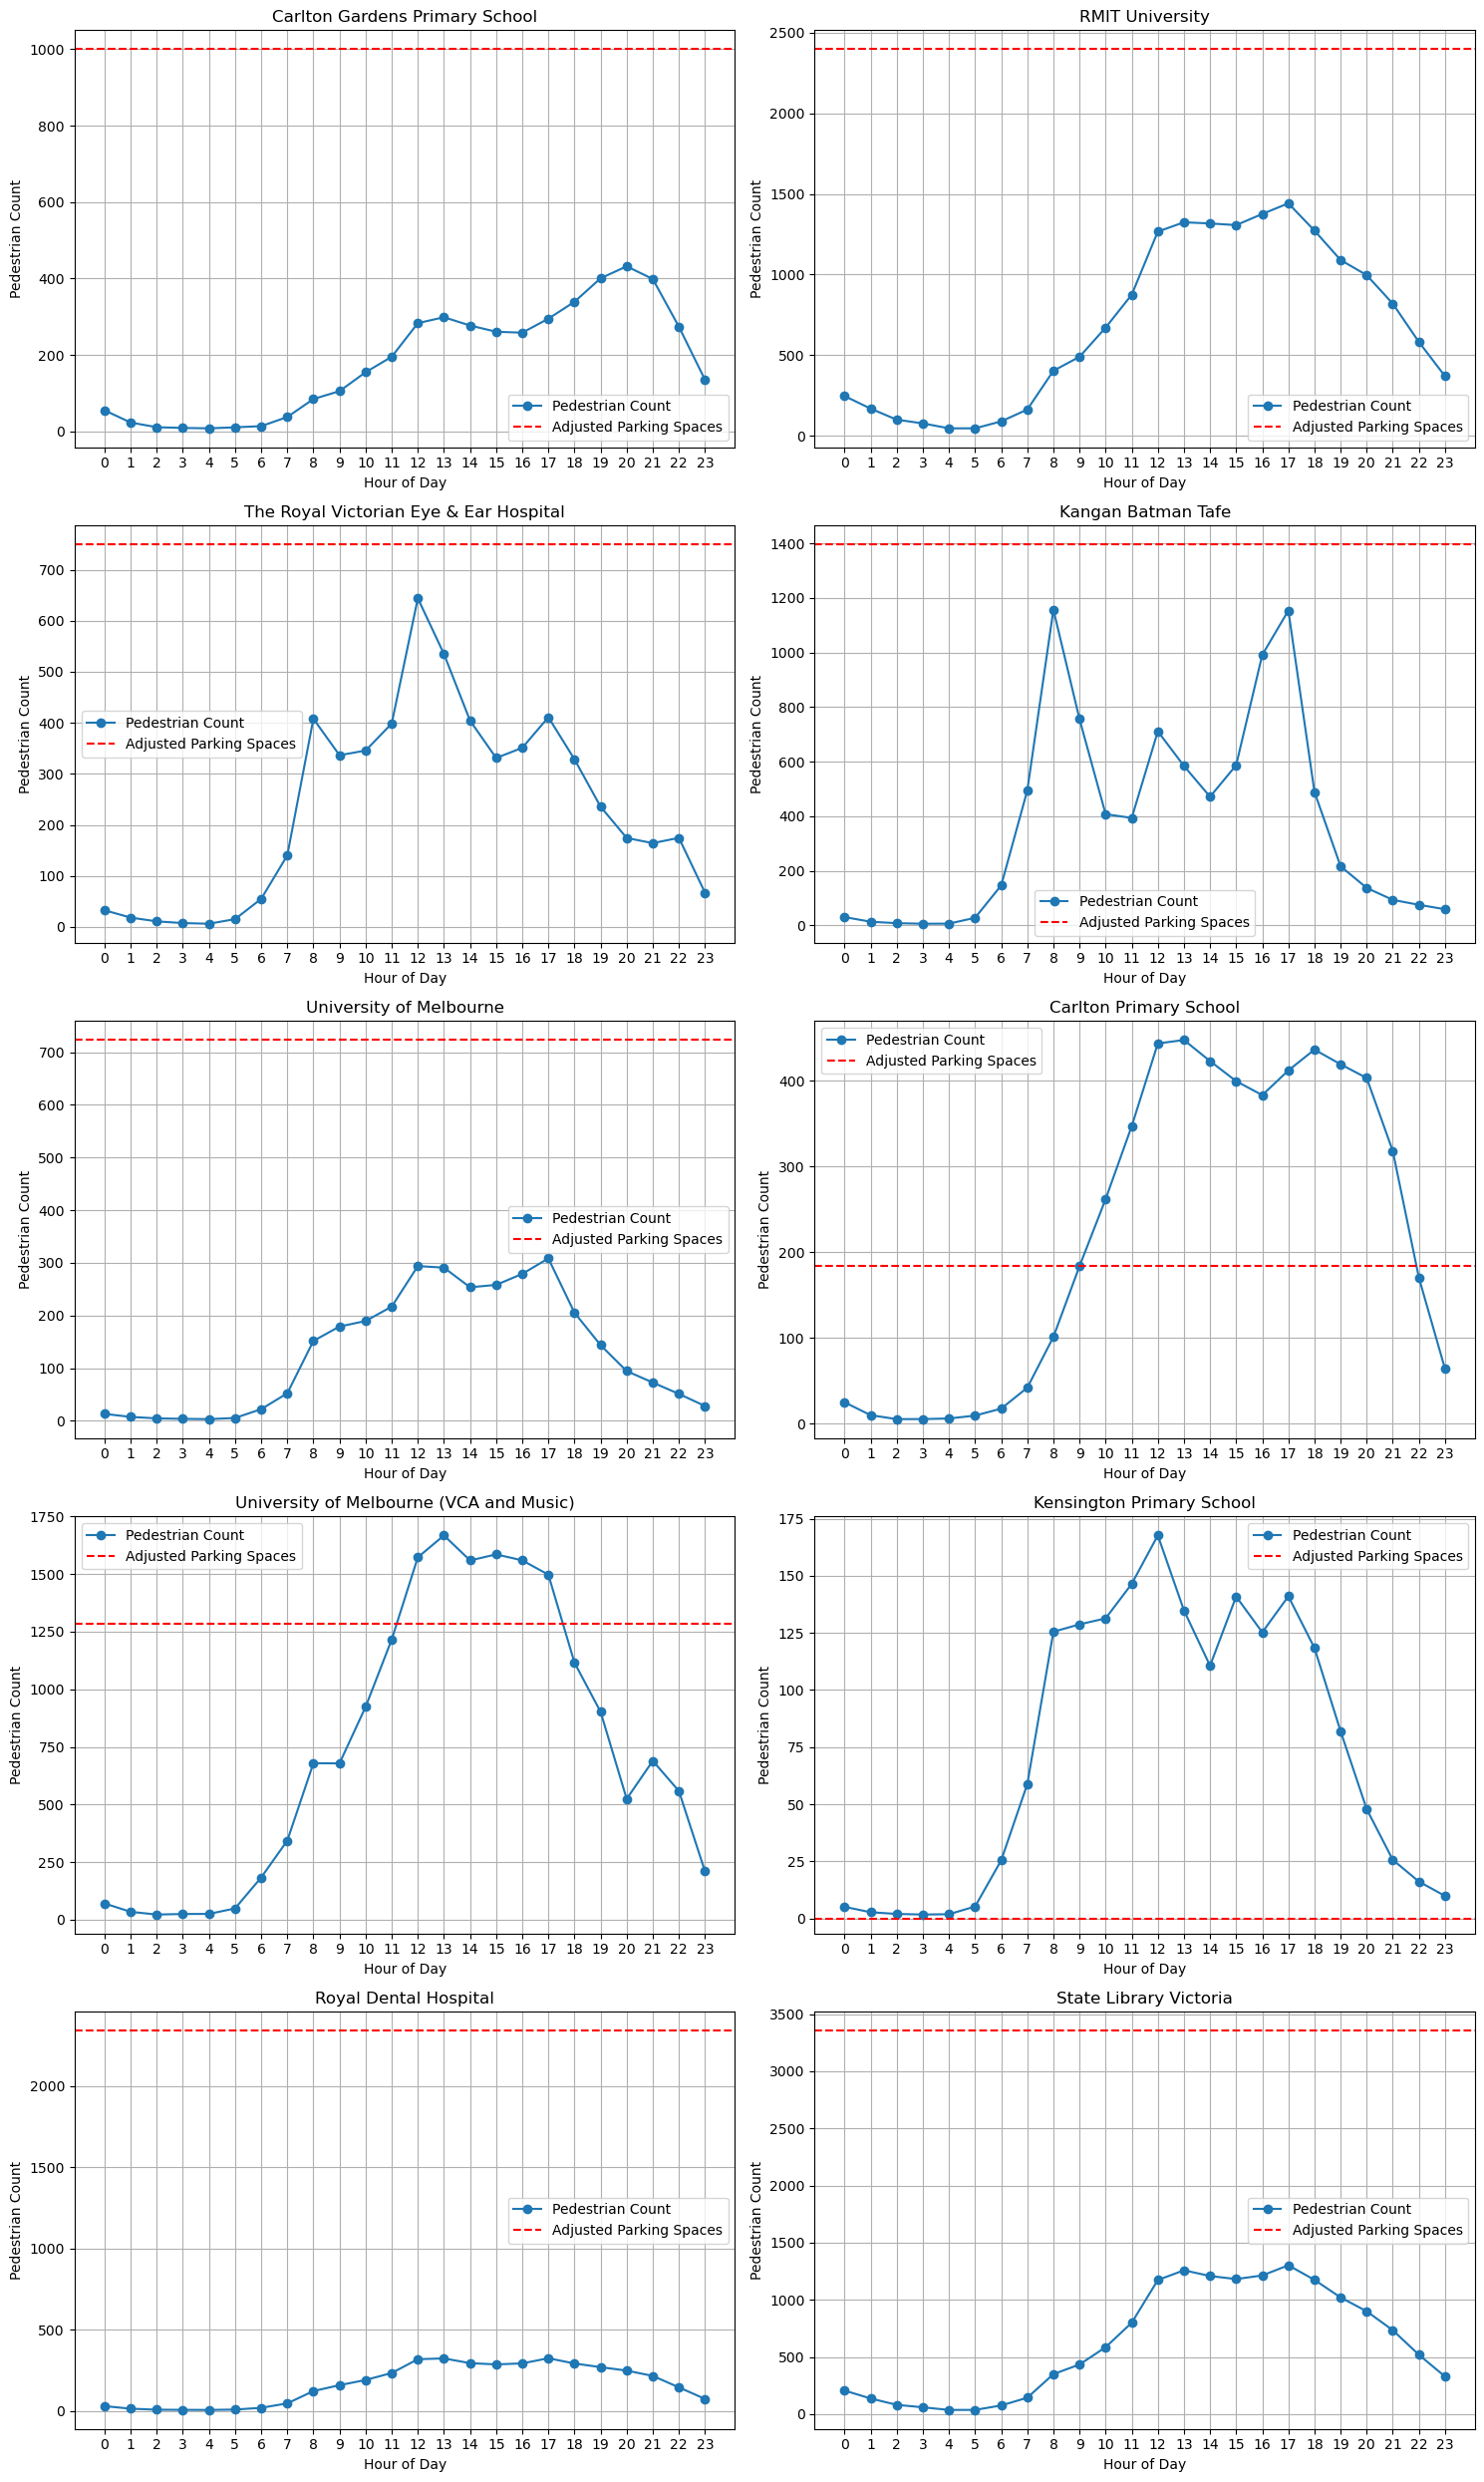

In [30]:
#filter landmarks with sensor data
landmarks_with_sensor = landmark_access_summary[landmark_access_summary['peak_pedestrian_count'] > 0]

total_landmarks = len(landmarks_with_sensor)
plots_per_row = 2
total_rows = math.ceil(total_landmarks / plots_per_row)


fig, axs = plt.subplots(total_rows, plots_per_row, figsize=(15, total_rows * 5))
axs = axs.flatten()  # make it easier to index

for i, (_, row) in enumerate(landmarks_with_sensor.iterrows()):
    landmark_name = row['feature_name']

    #landmark location
    landmark_row = filtered_landmarks[filtered_landmarks['feature_name'] == landmark_name].iloc[0]
    landmark_location = (landmark_row['latitude'], landmark_row['longitude'])

    #find nearby pedestrian sensors
    nearby_sensors = filtered_pedestrian[filtered_pedestrian.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400, axis=1
    )]

    ped_by_hour = nearby_sensors.groupby('hourday')['pedestriancount'].mean().reset_index()
    adjusted_spaces = row['adjusted_total_public_spaces']

    ax = axs[i]
    ax.plot(ped_by_hour['hourday'], ped_by_hour['pedestriancount'], marker='o', label='Pedestrian Count')
    ax.axhline(y=adjusted_spaces, color='red', linestyle='--', label='Adjusted Parking Spaces')
    ax.set_title(f"{landmark_name}", fontsize=12)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Pedestrian Count")
    ax.set_xticks(range(0, 24))
    ax.legend()
    ax.grid(True)

if total_landmarks % plots_per_row != 0:
    for j in range(total_landmarks, len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Key Insights:

- **Some landmarks, like Carlton Gardens Primary School and Carlton Primary School**, showed peak pedestrian counts that approached or exceeded their parking availability during the day. This indicates potential high demand or risk of parking shortages at certain peak times.

- **Major universities such as RMIT University and University of Melbourne (VCA and Music)** experienced very high pedestrian flows, yet still maintained parking supply above the peak pedestrian counts, suggesting relatively good parking accessibility.

- **Hospitals (e.g., Royal Victorian Eye & Ear Hospital and Royal Dental Hospital)** also had times where pedestrian volumes increased notably, but most remained within the parking capacity limits.

- **State Library Victoria**, although not a healthcare or education institution, showed steady foot traffic throughout the day but still within the parking capacity.

In summary, most landmarks generally have enough parking capacity during peak pedestrian times. However, smaller facilities and some schools may face challenges during peak hours. These areas may require further monitoring or parking management solutions.



# Data visualisation
## Interactive Map of landmark accessibility

In [33]:
map_center = [-37.8136, 144.9631]
melb_map = folium.Map(location=map_center, zoom_start=14)

unique_sensors = filtered_pedestrian[['location_id', 'latitude', 'longitude']].drop_duplicates()
unique_sensors.head()

for _, row in landmark_access_summary.iterrows():
    #check if sensor data exists
    has_sensor = row['avg_pedestrian_count'] != 0

    marker_color = 'blue' if has_sensor else 'gray'

    avg_ped_display = 'no data' if not has_sensor else row['avg_pedestrian_count']
    adjusted_space = round(row['adjusted_total_public_spaces'], 1) if not pd.isna(row['adjusted_total_public_spaces']) else 'no data'
    peak_hour_display = f"<b>Peak Hour:</b> {row['peak_hour']}:00" if has_sensor and row['peak_hour'] != 'no data' else ""

    popup_text = f"""
    <b>{row['feature_name']}</b><br>
    Type: {row['theme']}<br>
    Nearby Public Car Parks: {row['nearby_public_carparks']}<br>
    Adjusted Parking Spaces: {adjusted_space}<br>
    Avg Pedestrian Count: {avg_ped_display}<br>
    {peak_hour_display}
    """

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=500),
        icon=folium.Icon(color=marker_color, icon='info-sign')
    ).add_to(melb_map)

    for _, row in unique_sensors.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color='green',
            fill=True,
            fill_opacity=0.7,
            popup=f"Sensor Location ID: {row['location_id']}"
        ).add_to(melb_map)

legend = MacroElement()
#legend._template = Template(legend_html)
melb_map.get_root().add_child(legend)

melb_map




This map shows important public landmarks in Melbourne,like hospitals, schools, and libraries along with useful information about parking and pedestrian activity nearby. Each blue marker represents one of these landmarks. When you click on a marker, a box pops up with these details, which are type, nearby public car parks, total parking spaces, avg pedestrian count, and peak hour.

In [35]:
map_center = [-37.8136, 144.9631]
combined_map = folium.Map(location=map_center, zoom_start=14)

#colors for demand risk
risk_colors = {
    'Low': 'green',
    'Moderate': 'orange',
    'High': 'red'
}

#add landmarks with demand risk colors (Only with valid sensor data)
valid_data = landmark_access_summary[landmark_access_summary['peak_pedestrian_count'] > 0]

for _, row in valid_data.iterrows():
    risk_level = row['demand_risk']
    marker_color = risk_colors.get(risk_level, 'gray')

    popup_text = f"""
    <b>{row['feature_name']}</b><br>
    Type: {row['theme']}<br>
    Peak Pedestrian Count: {row['peak_pedestrian_count']}<br>
    Adjusted Parking Spaces: {round(row['adjusted_total_public_spaces'], 1)}<br>
    Parking Demand Risk: <b>{risk_level}</b>
    """

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=400),
        icon=folium.Icon(color=marker_color, icon='info-sign')
    ).add_to(combined_map)

#add Bus Stops
for _, row in filtered_bus_stop.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='orange',
        fill=True,
        fill_opacity=0.7,
        popup="Bus Stop"
    ).add_to(combined_map)

#add Tram Stops
for _, row in filtered_tram_stop.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='purple',
        fill=True,
        fill_opacity=0.7,
        popup="Tram Stop"
    ).add_to(combined_map)

legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 230px; height: 160px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;">
    <b>Map Legend</b><br>
    <div style='display:inline-block;width:12px;height:12px;background-color:red;margin-right:10px;'></div> High Parking Demand Risk<br>
    <div style='display:inline-block;width:12px;height:12px;background-color:orange;margin-right:10px;'></div> Moderate Parking Demand Risk<br>
    <div style='display:inline-block;width:12px;height:12px;background-color:green;margin-right:10px;'></div> Low Parking Demand Risk<br>
    <div style='display:inline-block;width:12px;height:12px;background-color:gray;margin-right:10px;'></div> Unknown Parking Demand Risk<br>
    <div style='display:inline-block;width:12px;height:12px;background-color:orange;margin-right:10px;'></div> Bus Stops<br>
    <div style='display:inline-block;width:12px;height:12px;background-color:purple;margin-right:10px;'></div> Tram Stops
</div>
"""

legend = MacroElement()
legend._template = Template(legend_html)
combined_map.get_root().add_child(legend)

combined_map


In [36]:
combined_map.save("combined_map.html")

In [37]:
risk_groups = landmark_access_summary.groupby('demand_risk')['feature_name'].apply(list)

markdown_text = "### Parking Demand Summary\n\n"

# Define risk order to control order in markdown
risk_order = ["High", "Moderate", "Low"]

for risk_level in risk_order:
    landmarks = risk_groups.get(risk_level, [])
    
    markdown_text += f"#### {risk_level} Risk\n"
    
    if landmarks:
        for landmark in landmarks:
            markdown_text += f"- {landmark}\n"
    else:
        markdown_text += "- None\n"
    
    markdown_text += "\n"

# Show markdown result
print(markdown_text)


### Parking Demand Summary

#### High Risk
- Carlton Primary School
- Kensington Primary School

#### Moderate Risk
- The Royal Victorian Eye & Ear Hospital
- Kangan Batman Tafe
- University of Melbourne (VCA and Music)

#### Low Risk
- Carlton Gardens Primary School
- RMIT University
- University of Melbourne
- Royal Dental Hospital
- State Library Victoria




# Model building

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       1.00      0.50      0.67         2
    Moderate       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.33      0.17      0.22         3
weighted avg       0.67      0.33      0.44         3



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

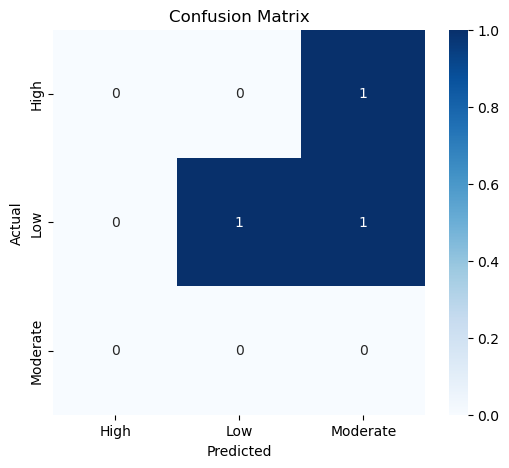

In [62]:
model_data = landmark_access_summary[[
    'adjusted_total_public_spaces',
    'peak_pedestrian_count',
    'nearby_bus_stops',
    'nearby_tram_tracks',
    'demand_risk'
]].copy()

model_data = model_data[model_data['peak_pedestrian_count'] > 0]

le = LabelEncoder()
model_data['demand_risk_encoded'] = le.fit_transform(model_data['demand_risk'])

# split features and target
X = model_data[['adjusted_total_public_spaces', 'peak_pedestrian_count', 'nearby_bus_stops', 'nearby_tram_tracks']]
y = model_data['demand_risk_encoded']

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Parking Demand Summary

| Risk Level | Landmarks |
|------------|-----------|
| High       | - Carlton Primary School <br> - Kensington Primary School <br> |
| Moderate   | - The Royal Victorian Eye & Ear Hospital <br> - Kangan Batman Tafe <br> - University of Melbourne (VCA and Music) |
| Low        | - Carlton Gardens Primary School <br> - RMIT University <br> - University of Melbourne <br> - Royal Dental Hospital |
